# 导入所需的库

- 标准库：
  - heapq: 堆数据结构
  - collections：容器
  - struct：c风格结构体二进制包装与操作
- 第三方库：
  - PIL：图片读取和处理
  - numpy：数学计算
  - pywt: PyWavelets 小波工具包
  - cv2: OpenCV 视觉工具包
- 自定义库：
  - utils：工具库

In [316]:
import heapq
import struct
from pathlib import Path
from collections import Counter

import numpy as np
import pywt
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from bitarray import bitarray

import utils

In [317]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

定义常量：

- BYTE_LENGTH: 一个字节的长度，4

In [318]:
BYTE_LENGTH = 4
BYTE_BIT = BYTE_LENGTH * 8
Q_FACTOR = 5
TILE_SIZE = 8

# 一、JPEG2000 编码流程

## 1.1 图像分块 (Tiling)

    输入图像首先被分割成若干个大小一致的矩形块，称为Tiles。这使得可以独立地处理和压缩图像的每一个部分，有利于并行处理和区域解码。

注意：

> PIL.Image.Image 的 size 属性获取的是 (w, h)
> np.ndarray 的 shape 属性获取的是 (h, w, c)

In [319]:
def tile_pil_image(image, tile_size):
    """
    将图像分割成指定大小的块
    :param image: 输入图像，PIL.Image.Image对象
    :param tile_size: 块大小(w, h)，整数或元组
    :return: 图像块列表
    """
    tiles = []
    w, h = image.size

    if isinstance(tile_size, int):
        tile_size = utils.turn2pair(tile_size)
    
    tile_w, tile_h = tile_size

    for x in range(0, w, tile_w):
        for y in range(0, h, tile_h):
            box = (x, y, x+tile_w, y+tile_h)
            tile = image.crop(box)
            tiles.append(tile)
    return tiles

def tile_np_image(image, tile_size):
    """
    将图像分割成指定大小的块
    :param image: 输入图像，NumPy数组
    :param tile_size: 块大小(h, w)，整数或元组
    :return: 图像块列表
    """
    h, w = image.shape[:2]
    tiles = []
    
    if isinstance(tile_size, int):
        tile_size = utils.turn2pair(tile_size)
    
    tile_h, tile_w = tile_size
    
    # 遍历图像并提取块
    for x in range(0, w, tile_w):
        for y in range(0, h, tile_h):
            tile = image[y:y+tile_h, x:x+tile_w]
            tiles.append(tile)
    
    return tiles

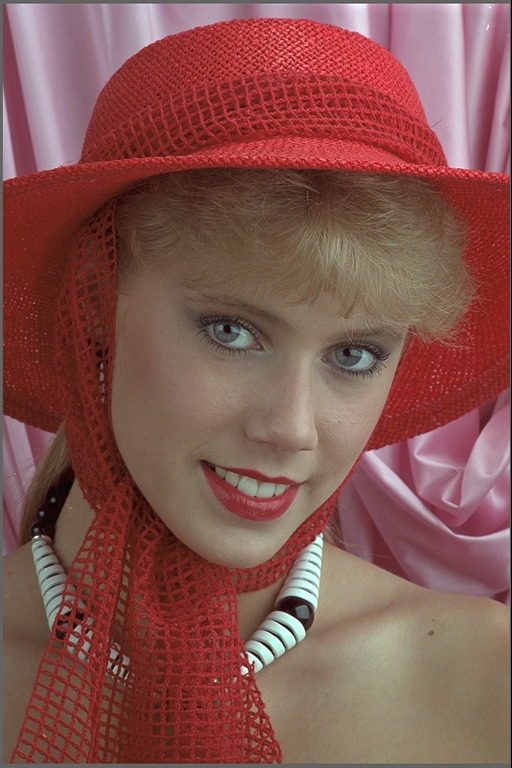

行数：6.0, 列数：4.0
原图大小：(768, 512, 3)
图片分块后的块数：6144


In [320]:
cv_img = cv2.imread('./img/src_img/kodim04.png')

image_shape = cv_img.shape[:2]

utils.np2pil(cv_img)
cv_tiles = tile_np_image(cv_img, TILE_SIZE)
print(f"行数：{768/128}, 列数：{512/128}")
print(f"原图大小：{cv_img.shape}")
print(f"图片分块后的块数：{len(cv_tiles)}")


## 1.2 颜色变换 (Color Transform)

    对彩色图像进行颜色空间转换。通常将RGB颜色空间转换为YUV颜色空间，从而将颜色信息分成亮度和色度分量，有利于更高效的压缩。

  > 参考：[opencv与PIL互相转换](https://blog.csdn.net/weixin_50113231/article/details/123004037)

In [321]:
def convertColor2YUV(image):
    """
    颜色变换：从RGB转换到YUV
    :param image: 输入图像, PIL.Image.Image 或 np.ndarray
    :return: YUV图像 np.ndarray
    """
    yuv_img = None
    if isinstance(image, Image.Image):
        yuv_img = cv2.cvtColor(utils.pil2np(image), cv2.COLOR_RGB2YUV)
    else:
        yuv_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return yuv_img

In [322]:
yuv_tiles = [convertColor2YUV(tile) for tile in cv_tiles]
yuv_tiles[0].shape

(8, 8, 3)

## 1.3 离散小波变换 (Discrete Wavelet Transform, DWT)

    对每个图像块进行离散小波变换，将图像信息分解到不同的频带（子带）中。DWT有助于更有效地表示图像数据，尤其是高频细节部分。

In [323]:
def discrete_wavelet_transform_2d(image: np.ndarray):
    """
    对图像块进行离散小波变换
    :param image: 图像块（2D）
    :return: 小波变换系数
    """
    coeffs = pywt.dwt2(image, 'haar')
    return coeffs

In [324]:
# 示例DWT
# 3d的返回值：([128, 64, 2], ([128, 64, 2], [128, 64, 2], [128, 64, 2]))
coeffs_3d = discrete_wavelet_transform_2d(yuv_tiles[0])
# 2d的返回值：([64, 64], ([64, 64], [64, 64], [64, 64]))
coeffs_2d = discrete_wavelet_transform_2d(yuv_tiles[0][:, :, 0])
coeffs_2d[0].shape, coeffs_2d[1][0].shape, coeffs_2d[1][1].shape, coeffs_2d[1][2].shape
# utils.np2pil(coeffs[0], cv2.COLOR_YUV2RGB)

((4, 4), (4, 4), (4, 4), (4, 4))

## 1.4 量化 (Quantization)

    对小波变换后的系数进行量化，减少数据的精度以降低信息量。量化是一个有损压缩步骤，通过减少不重要的系数值来实现压缩。

In [325]:
def quantize(coeffs, q_factor):
    """
    对小波系数进行量化
    :param coeffs: 小波系数
    :param q_factor: 量化因子
    :return: 量化后的系数
    """
    cA, (cH, cV, cD) = coeffs
    cA = np.round(cA / q_factor)
    cH = np.round(cH / q_factor)
    cV = np.round(cV / q_factor)
    cD = np.round(cD / q_factor)
    return cA, (cH, cV, cD)

In [326]:
quantized_coeffs = quantize(coeffs_2d, 10)
# 量化后，形状不变：([64, 64], ([64, 64], [64, 64], [64, 64]))
f"[{quantized_coeffs[0].shape}, [{quantized_coeffs[1][0].shape}, {quantized_coeffs[1][1].shape}, {quantized_coeffs[1][2].shape}]]"

'[(4, 4), [(4, 4), (4, 4), (4, 4)]]'

## 1.5 zigzag扫描与RLE编码

In [327]:
def zigzag_indices_generator(size: int) -> np.ndarray:
    """
    生成给定大小的矩阵的 Zigzag 扫描顺序索引矩阵。
    :param size: int 矩阵的大小 (size x size)
    :return: np.ndarray Zigzag 扫描顺序的索引矩阵
    """
    dct_vector = []
    for dim_sum in range(2, (size + size) + 1):
        if dim_sum % 2 == 0:
            for i in range(1, size + 1):
                if 0 < dim_sum - i <= size:
                    # dct_vector.append(A[i - 1, dim_sum - i - 1])
                    dct_vector.append((i - 1)+(dim_sum - i - 1)*size)
                    # print(f"x: {i-1}, y: {dim_sum - i - 1}, index: {(i - 1)+(dim_sum - i - 1)*A.shape[0]}, value: {A[i - 1, dim_sum - i - 1]}")
        else:
            for i in range(1, size + 1):
                if 0 < dim_sum - i <= size:
                    # dct_vector.append(A[dim_sum - i - 1, i - 1])
                    dct_vector.append((dim_sum - i - 1)+(i - 1)*size)
                    # print(f"x: {dim_sum - i - 1}, y: {i - 1}, index: {(dim_sum - i - 1)+(i - 1)*A.shape[0]}, value: {A[dim_sum - i - 1, i - 1]}")

    return np.array(dct_vector)


In [328]:
size = 8
a = zigzag_indices_generator(size).reshape(size, size)
b = np.array([
    [1, 2, 6, 7, 15, 16, 28, 29],    
    [3, 5, 8, 14, 17, 27, 30, 43],    
    [4, 9, 13, 18, 26, 31, 42, 44],    
    [10, 12, 19, 25, 32, 41, 45, 54],    
    [11, 20, 24, 33, 40, 46, 53, 55],    
    [21, 23, 34, 39, 47, 52, 56, 61],    
    [22, 35, 38, 48, 51, 57, 60, 62],    
    [36, 37, 49, 50, 58, 59, 63, 64]    
])

c = b.flatten()[a.flatten()].reshape(8, 8)
c
d = c.flatten()[a.flatten()].reshape(8, 8)
d

array([[ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16],
       [17, 18, 19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30, 31, 32],
       [33, 34, 35, 36, 37, 38, 39, 40],
       [41, 42, 43, 44, 45, 46, 47, 48],
       [49, 50, 51, 52, 53, 54, 55, 56],
       [57, 58, 59, 60, 61, 62, 63, 64]])

array([[ 1,  2,  9, 17, 10,  3,  4, 11],
       [18, 25, 33, 26, 19, 12,  5,  6],
       [13, 20, 27, 34, 41, 49, 42, 35],
       [28, 21, 14,  7,  8, 15, 22, 29],
       [36, 43, 50, 57, 58, 51, 44, 37],
       [30, 23, 16, 24, 31, 38, 45, 52],
       [59, 60, 53, 46, 39, 32, 40, 47],
       [54, 61, 62, 55, 48, 56, 63, 64]])

In [329]:

# 1. zigzag扫描
def zigzag_scan(block, tile_size):
    zigzag_indices = zigzag_indices_generator(tile_size)
    # zigzag_indices = np.array([
    #     [0, 1, 5, 6, 14, 15, 27, 28],
    #     [2, 4, 7, 13, 16, 26, 29, 42],
    #     [3, 8, 12, 17, 25, 30, 41, 43],
    #     [9, 11, 18, 24, 31, 40, 44, 53],
    #     [10, 19, 23, 32, 39, 45, 52, 54],
    #     [20, 22, 33, 38, 46, 51, 55, 60],
    #     [21, 34, 37, 47, 50, 56, 59, 61],
    #     [35, 36, 48, 49, 57, 58, 62, 63]
    # ])
    # print(tile_size)
    # print(block.shape)
    # print(zigzag_indices.shape)
    return block.flatten()[zigzag_indices.flatten()]


In [330]:
cA, (cH, cV, cD) = quantized_coeffs

top = np.vstack((cA, cH))
bottom = np.vstack((cV, cD))
block = np.hstack((top, bottom))

zigzag = zigzag_scan(block, TILE_SIZE)
len(zigzag)
zigzag

64

array([20., 20., 20., 20., 20., 20., 20., 20., 18., 20.,  0., 18., 18.,
       21.,  0.,  0.,  0., 27., 17.,  0.,  0.,  0.,  1.,  0., 25.,  0.,
        0.,  0.,  0., -0.,  2.,  0.,  0.,  0., -0.,  0.,  0.,  0., -2.,
        0.,  2., -2., -0., -2., -1.,  0.,  0.,  1.,  0.,  0.,  0., -0.,
        0., -2.,  0.,  1.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.])

In [331]:
# 2. 对DCT系数进行游程编码
def run_length_encode(zigzag):
    result = []
    pre_val = zigzag[0]
    count = 1
    for value in zigzag[1:]:
        if value == pre_val:
            count += 1
        else:
            result.append((count, pre_val))
            pre_val = value
            count = 1
    result.append((count, pre_val))
    return result

In [332]:
rle_codes = run_length_encode(zigzag)
len(rle_codes)
# rle_codes

30

## 1.5 熵编码 (Entropy Coding)

    使用算术编码或EBCOT (Embedded Block Coding with Optimal Truncation) 对量化后的系数进行熵编码。EBCOT是一种先进的编码方法，能够自适应地对数据进行压缩并提供渐进式解码功能。

    暂时还没实现EBCOT，使用的是哈夫曼编码

In [333]:
def serialize_huffman_tree(huffman_tree):
    """
    序列化霍夫曼树以便存储
    :param huffman_tree: 霍夫曼树
    :return: 序列化的霍夫曼树
    """
    serialized_tree = []
    for symbol, code in huffman_tree:
        serialized_tree.append((symbol, code))
    return serialized_tree


def huffman_encoding(data):
    """
    霍夫曼编码
    :param data: 输入数据
    :return: 编码后的数据和霍夫曼树
    """
    if len(data) == 1:
        return "0", serialize_huffman_tree([[data[0], '0']])
    frequency = Counter(data)
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    
    huffman_tree = sorted(heapq.heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
    huffman_dict = {symbol: code for symbol, code in huffman_tree}
    encoded_data = "".join(huffman_dict[symbol] for symbol in data)
    # print("hfd:", huffman_tree)
    serialized_tree = serialize_huffman_tree(huffman_tree)

    return encoded_data, serialized_tree


In [334]:
# rle_codes
add_rle_codes = [(64, 20.0), (20, 1.0)]
"rle_codes:"
encoded_data, huffman_dict = huffman_encoding(rle_codes)
len(huffman_dict), len(encoded_data)
# huffman_dict, encoded_data
"add_rle_codes:"
encoded_data, huffman_dict = huffman_encoding(add_rle_codes)
len(huffman_dict), len(encoded_data)
huffman_dict, encoded_data

'rle_codes:'

(18, 118)

'add_rle_codes:'

(2, 2)

([((20, 1.0), '0'), ((64, 20.0), '1')], '10')

## 1.6 码流组织 (Bitstream Organization)

    将编码后的数据组织成一个压缩码流，包含图像块的头信息、量化参数、熵编码数据等。这些数据可以按需分层和分级，以支持不同分辨率和质量的解码。

In [335]:
def organize_bitstream(blocks, q_factor, tile_size=128):
    """
    组织码流
    :param blocks: 图像块列表
    :param q_factor: 量化因子
    :return: 码流
    """
    bitstream = bitarray()
    serialized_trees = []
    temp = bitarray()
    for block in blocks:
        # 对每个通道进行小波变换和量化
        for channel in range(block.shape[2]):
            coeffs = discrete_wavelet_transform_2d(block[:,:,channel])
            quantized_coeffs = quantize(coeffs, q_factor)

            # 将量化后的系数写入码流
            cA, (cH, cV, cD) = quantized_coeffs
            flat_array = np.hstack((cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten())).astype(int)

            zigzag = zigzag_scan(flat_array, tile_size)
            rle_codes = run_length_encode(zigzag)

            # print(rle_codes)
            # 霍夫曼编码
            encoded_data, serialized_tree = huffman_encoding(rle_codes)
            serialized_trees.append(serialized_tree)

            # 将编码后的数据写入码流
            # MODIFY: 存储优化
            # print(encoded_data)
            data = bitarray(encoded_data)
            # 数据长度(记录数据位数，占据4字节)
            temp.clear()
            temp.frombytes(struct.pack('I', len(data)))
            bitstream.extend(temp)
            # 数据
            bitstream.extend(data)
            # 哈夫曼树的长度
            temp.clear()
            temp.frombytes(struct.pack('I', len(serialized_tree)))
            bitstream.extend(temp)
            # 哈夫曼的键值对
            for symbol, code in serialized_tree:
                # symbol
                temp.clear()
                temp.frombytes(struct.pack('I', symbol[0]))
                bitstream.extend(temp)
                temp.clear()
                temp.frombytes(struct.pack('i', symbol[1]))
                bitstream.extend(temp)
                # code 位数
                # MODIFY: 存储优化
                data = bitarray(code)
                temp.clear()
                temp.frombytes(struct.pack('I', len(data)))
                bitstream.extend(temp)
                # code值
                bitstream.extend(data)

    return bitstream, serialized_trees

def save_bitstream(file_path, bitstream):
    """
    将码流保存到文件
    :param file_path: 文件路径
    :param bitstream: 码流
    """
    with open(file_path, 'wb') as f:
        bitstream.tofile(f)

In [336]:
bitstream, huffman_trees = organize_bitstream(cv_tiles, q_factor=Q_FACTOR, tile_size=TILE_SIZE)
file_path = "./img/encoded_img/test.jp2"
print(f"{len(bitstream)=}")
save_bitstream(file_path, bitstream)
print(f"{file_path}文件已保存,文件大小为：{Path(file_path).stat().st_size/1024:,.2f}KB!")

len(bitstream)=39670918
./img/encoded_img/test.jp2文件已保存,文件大小为：4,842.64KB!


## 1.7 编码流程整合

    将编码流程整合到一起实现图像编码。

In [337]:
from pathlib import Path

def encode_jpeg2000(image_path, save_path, q_factor=5, tile_size=128):
    img = cv2.imread(image_path)
    img = convertColor2YUV(img)
    tiles = tile_np_image(img, tile_size)
    bitstream, huffman_trees = organize_bitstream(tiles, q_factor, tile_size)
    print(f"{len(bitstream)=}")
    save_bitstream(save_path, bitstream)
    print(f"{save_path}文件已保存！文件大小为：{Path(save_path).stat().st_size/1024:,.2f}KB")
    print(f"{image_path}文件大小为：{Path(image_path).stat().st_size/1024:,.2f}KB")

In [338]:
encode_jpeg2000('./img/src_img/kodim04.png', './img/encoded_img/encoded_kodim04.jp2', q_factor=Q_FACTOR, tile_size=TILE_SIZE)

len(bitstream)=28342416
./img/encoded_img/encoded_kodim04.jp2文件已保存！文件大小为：3,459.77KB
./img/src_img/kodim04.png文件大小为：622.49KB


# 二、解码过程

## 2.1 码流解析 (Bitstream Parsing) 

    解码器首先解析压缩码流，提取图像块的头信息、量化参数、熵编码数据等。

## 2.2 熵解码 (Entropy Decoding) 

    对熵编码的数据进行解码，恢复量化后的小波系数。

In [339]:
def deserialize_huffman_tree(serialized_tree):
    """
    反序列化霍夫曼树
    :param serialized_tree: 序列化的霍夫曼树
    :return: 霍夫曼树
    """
    huffman_tree = []
    for symbol, code in serialized_tree:
        huffman_tree.append((symbol, code))
    return huffman_tree

def huffman_decoding(encoded_data, huffman_tree):
    """
    霍夫曼解码
    :param encoded_data: 编码后的数据
    :param huffman_tree: 霍夫曼树
    :return: 解码后的数据
    """
    huffman_dict = {code: symbol for symbol, code in huffman_tree}
    decoded_data = []
    # print(encoded_data)
    code = ""
    for bit in encoded_data:
        code += bit
        if code in huffman_dict:
            decoded_data.append(huffman_dict[code])
            code = ""
    # print(decoded_data)
    return decoded_data

In [340]:
def decode_bitstream(file_path):
    """
    解码码流
    :param file_path: 文件路径
    :return: 图像数据
    """
    bitstream = bitarray()
    with open(file_path, 'rb') as f:
        bitstream.fromfile(f)

    offset = 0
    data_blocks = []
    while offset < len(bitstream):
        if (len(bitstream) - offset) < 8:
            break
        # 读取编码数据的长度
        # MODIFY: 存储优化
        byte_4 = bitstream[offset:offset+BYTE_BIT].tobytes()
        data_length = struct.unpack('I', byte_4)[0]
        offset += BYTE_BIT
        # 读取编码数据
        encoded_data = bitstream[offset:offset + data_length].to01()
        # print(data_length)
        offset += data_length

        # 读取霍夫曼树的长度
        byte_4 = bitstream[offset:offset+BYTE_BIT].tobytes()
        huffman_tree_length = struct.unpack('I', byte_4)[0]
        offset += BYTE_BIT
        
        # 读取霍夫曼树
        serialized_tree = []
        for _ in range(huffman_tree_length):
            # symbol
            byte_4 = bitstream[offset:offset+BYTE_BIT].tobytes()
            symbol_0 = struct.unpack('I', byte_4)[0]
            offset += BYTE_BIT
            byte_4 = bitstream[offset:offset+BYTE_BIT].tobytes()
            symbol_1 = struct.unpack('i', byte_4)[0]
            offset += BYTE_BIT
            symbol = (symbol_0, symbol_1)

            # MODIFY: 存储优化
            # code_length
            byte_4 = bitstream[offset:offset+BYTE_BIT].tobytes()
            data_length = struct.unpack('I', byte_4)[0]
            offset += BYTE_BIT
            # code
            code = bitstream[offset:offset + data_length].to01()
            offset += data_length
            
            serialized_tree.append((symbol, code))
        
        # 反序列化霍夫曼树
        huffman_tree = deserialize_huffman_tree(serialized_tree)
        # 霍夫曼解码
        decoded_data = huffman_decoding(encoded_data, huffman_tree)

        # 将解码数据添加到块列表
        data_blocks.append(decoded_data)
    
    return data_blocks

In [341]:
data_blocks = decode_bitstream('./img/encoded_img/test.jp2')
len(data_blocks)
type(data_blocks[0])
len(data_blocks[0])
# data_blocks

18432

list

44

## 2.3 游程编码解码与zigzag解码

In [342]:
# 2. 解析RLE编码
def run_length_decode(flat_rle):
    all_rle_decoded = []
    for item in flat_rle:
        for _ in range(item[0]):
            all_rle_decoded.append(item[1])
    return all_rle_decoded


# 3. 还原zigzag扫描顺序
def inverse_zigzag_scan(zigzag, tile_size):
    zigzag_indices = zigzag_indices_generator(tile_size)
    # zigzag_indices = np.array([
    #     [0, 1, 5, 6, 14, 15, 27, 28],
    #     [2, 4, 7, 13, 16, 26, 29, 42],
    #     [3, 8, 12, 17, 25, 30, 41, 43],
    #     [9, 11, 18, 24, 31, 40, 44, 53],
    #     [10, 19, 23, 32, 39, 45, 52, 54],
    #     [20, 22, 33, 38, 46, 51, 55, 60],
    #     [21, 34, 37, 47, 50, 56, 59, 61],
    #     [35, 36, 48, 49, 57, 58, 62, 63]
    # ]).flatten()
    block = np.zeros((tile_size, tile_size), dtype=np.float32)
    block_flat = block.flatten()
    zigzag_array = np.array(zigzag, dtype=np.float32)
    # print(f"{block_flat.shape=}, {zigzag_array.shape=}")
    # print(f"{zigzag_array=}")
    for i, index in enumerate(zigzag_indices.flatten()):
        block_flat[index] = zigzag_array[i]
    return block_flat.reshape((tile_size, tile_size))

In [343]:
new_zigzag = run_length_decode(rle_codes)
len(new_zigzag)
# new_zigzag
data = inverse_zigzag_scan(new_zigzag, TILE_SIZE)
data.shape, TILE_SIZE*TILE_SIZE

64

((8, 8), 64)

## 2.3 反量化 (Inverse Quantization)

    对量化后的小波系数进行反量化，恢复小波变换的系数值。

In [344]:
def inverse_quantize(quantized_coeffs, q_factor):
    """
    反量化小波系数
    :param quantized_coeffs: 量化后的系数
    :param q_factor: 量化因子
    :return: 反量化后的系数
    """
    cA, (cH, cV, cD) = quantized_coeffs
    cA = cA * q_factor
    cH = cH * q_factor
    cV = cV * q_factor
    cD = cD * q_factor
    return cA, (cH, cV, cD)

In [345]:
def block2array(block, tile_size=8, q_factor=5):
    half_size = int(tile_size / 2)
    fre_size = half_size**2
    cA = np.array(block[:fre_size]).reshape((half_size, half_size))
    cH = np.array(block[fre_size: fre_size*2]).reshape((half_size, half_size))
    cV = np.array(block[fre_size*2: fre_size*3]).reshape((half_size, half_size))
    cD = np.array(block[fre_size*3:]).reshape((half_size, half_size))
    return cA, (cH, cV, cD)

## 2.4 反离散小波变换 (Inverse Discrete Wavelet Transform, IDWT)

    对小波系数进行反离散小波变换，将数据从频域变换回空域，重建图像块的像素值。

In [346]:
def inverse_discrete_wavelet_transform(coeffs):
    """
    逆离散小波变换
    :param coeffs: 小波变换系数
    :return: 重建的图像块
    """
    return pywt.idwt2(coeffs, 'haar')

In [347]:
def block2coffs(block, tile_size):
    half_size = int(tile_size / 2)
    cA = block[:half_size, :half_size]
    cH = block[half_size:, :half_size]
    cV = block[:half_size, half_size:]
    cD = block[half_size:, half_size:]
    return cA, (cH, cV, cD)


In [348]:
def get_tiles_from_data(data_blocks, tile_size=8, q_factor=5):
    """
    从数据块还原图像块
    :param blocks: 解码后的图像块
    :param tile_size: 分块大小
    :return: 原始的图像块列表
    """
    reconstruct_tiles = []
    channels = []
    for block in data_blocks:
        # print(block)
        zigzag = run_length_decode(block)
        # print(f"{tile_size=}")
        data = inverse_zigzag_scan(zigzag, tile_size)
        # block_array = block2array(data, tile_size, q_factor)
        quantized_coeffs = block2coffs(data, tile_size)
        coeffs = inverse_quantize(quantized_coeffs, q_factor)
        single_channel = inverse_discrete_wavelet_transform(coeffs)
        # plt.figure()
        # plt.imshow(single_channel)
        # plt.show
        channels.append(single_channel)
        if len(channels) == 3:
            tile = np.stack(channels, axis=2)
            reconstruct_tiles.append(tile)
            channels.clear()
    return reconstruct_tiles

In [349]:
reconstruct_tiles = get_tiles_from_data(data_blocks, TILE_SIZE, Q_FACTOR)
f"number: {len(reconstruct_tiles)}, size: {reconstruct_tiles[0].shape}"
# plt.figure()
# plt.imshow(reconstruct_tiles[0])
# plt.show

'number: 6144, size: (8, 8, 3)'

## 2.5 颜色反变换 (Color Inverse Transform)

    对重建的图像块进行颜色反变换，将YUV颜色空间转换回RGB颜色空间，恢复原始颜色信息。

In [350]:
def convertColor2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_YUV2RGB)

## 2.6 图像块重组 (Tile Assembly)

    将解码后的图像块重新组合，形成完整的解码图像。

In [351]:
def merge_image(tiles, tile_size, image_shape):
    """
    将图像块重新组合并显示
    :param tiles: 图像块列表
    :param tile_size: 块大小(w, h)，整数或元组
    :param image_shape: 原始图像的形状(w, h)
    """
    h, w = image_shape

    if isinstance(tile_size, int):
        tile_size = utils.turn2pair(tile_size)

    tile_h, tile_w = tile_size
    # 创建一个空白图像用于展示块
    reassembled_image = np.zeros((h, w, 3), dtype=np.uint8)
    
    # 重新组合图像块
    idx = 0
    for x in range(0, w, tile_w):
        for y in range(0, h, tile_h):
            reassembled_image[y:y+tile_h, x:x+tile_w] = tiles[idx]
            idx += 1
    return reassembled_image

(768, 512, 3)

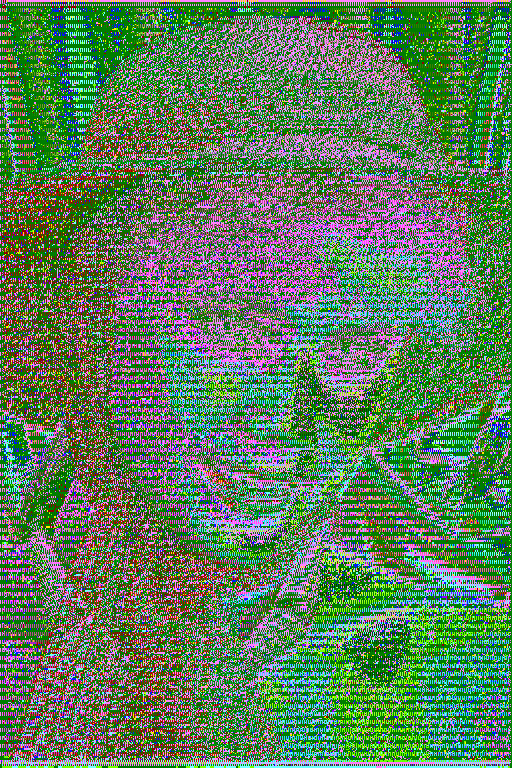

In [352]:
decode_img = merge_image(reconstruct_tiles, TILE_SIZE, image_shape)
# YUV -> RGB
decode_img = convertColor2RGB(decode_img)
decode_img.shape
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 8))
# plt.imshow(decode_img)
# plt.show()
utils.np2pil(decode_img, None)

## 2.7 解码流程整合

    整合整个解码流程。

In [353]:
def decode_jpeg2000(input_bitstream_path, output_image_path, image_shape, tile_size=128, q_factor=1.0):
    # 解码码流
    decoded_blocks = decode_bitstream(input_bitstream_path)
    reconstruct_tiles = get_tiles_from_data(decoded_blocks, tile_size, q_factor)
    decode_img = merge_image(reconstruct_tiles, tile_size, image_shape)
    decode_img = convertColor2RGB(decode_img)
    decode_img = cv2.cvtColor(decode_img, cv2.COLOR_BGR2RGB)
    # 保存重建的图像
    cv2.imwrite(output_image_path, decode_img)
    print(f"解码后的图像已保存到 {output_image_path},文件大小为：{Path(output_image_path).stat().st_size/1024:,.2f}KB!")

In [354]:
decode_jpeg2000('./img/encoded_img/encoded_kodim04.jp2', './img/decoded_img/decoded_kodim04.png', image_shape=image_shape, tile_size=TILE_SIZE, q_factor=Q_FACTOR)

解码后的图像已保存到 ./img/decoded_img/decoded_kodim04.png,文件大小为：744.73KB!
